In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
tqdm.pandas()

import pickle
import pyarrow.parquet as pq
import dask

C:\Users\_v010ch_\Anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
DATA = './data'
DATA_OWN = './data_own'
CLICKSTREAM = 'alfabattle2_abattle_clickstream'

In [4]:
data = pd.read_csv(os.path.join(DATA, 'alfabattle2_abattle_train_target.csv'), parse_dates=['timestamp']).sort_values(by = ['timestamp'])
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)
data.index.name = 'ind'
data.head()

,session_id,client_pin,timestamp,multi_class_target
ind,,,,
0,da4ab6bb6795a4eb6458b88af7fb2367,70783113e4f4117935d9f746237fce3e,2020-01-01 00:00:00,mobile_recharge
1,f99d13f31091099672e51c1a02e4c567,989f645a00e3e8a179036cf5fd5be29d,2020-01-01 00:00:00,statement
2,69301aa932f73dec3355b803a63c39fe,586fe605f61e81581efe72d9d3dc237d,2020-01-01 00:00:01,statement
3,c6ae8307a0214b526a0e6fca3a9b80f5,c825cc9d1dfefe1fbc0fa1ead60fe2e1,2020-01-01 00:00:23,statement
4,3fd49317a617d521e0865496ec797550,29928aba9d9bbf5e0377ddc6ec6f5294,2020-01-01 00:00:35,mobile_recharge


In [57]:
data.shape, data.client_pin.nunique()

((5065350, 9), 79268)

In [5]:
data['dom']  = data.timestamp.apply(lambda x: x.day)

<AxesSubplot:>

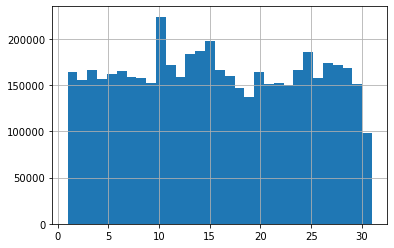

In [16]:
data['dom'].hist(bins = 31)

In [7]:
data['dow']  = data.timestamp.apply(lambda x: x.weekday())

<AxesSubplot:>

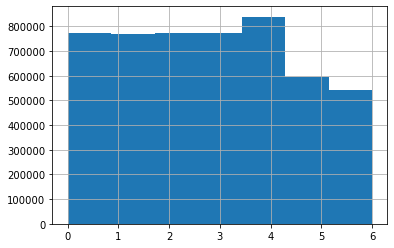

In [17]:
data['dow'].hist(bins = 7)

In [13]:
data['hour'] = data.timestamp.apply(lambda x: x.hour)

<AxesSubplot:>

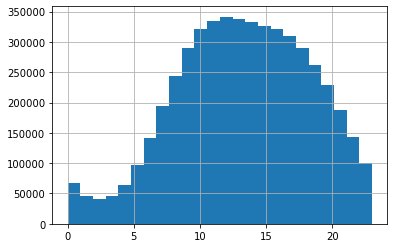

In [18]:
data['hour'].hist(bins = 24)

In [19]:
def get_time_of_day(inp_hour):
    if (inp_hour >= 12) and (inp_hour < 18):
        return 'day'
    elif (inp_hour >= 6) and (inp_hour < 12):
        return 'morning'
    elif (inp_hour >= 18) and (inp_hour <= 23):
        return 'evening'
    else:
        return 'night'

In [20]:
data['tod']  = data.hour.apply(get_time_of_day)

<AxesSubplot:>

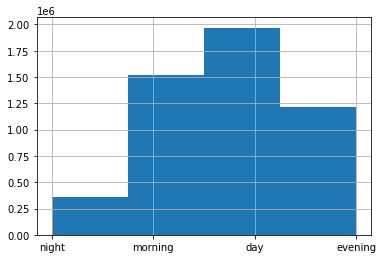

In [21]:
data['tod'].hist(bins = 4)

In [27]:
def week_moment(inp_dow):
    if (inp_dow == 5) or (inp_dow == 6):
        return 'weekend'
    else:
        return 'weekdays'

In [28]:
data['week_moment']  = data.dow.apply(week_moment)

<AxesSubplot:>

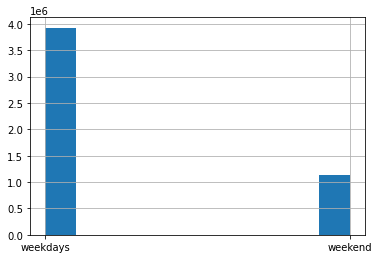

In [29]:
data['week_moment'].hist()

In [74]:
%%time
first_note = data.groupby('client_pin').timestamp.agg(['min', 'max'])
max(first_note['min']), max(first_note['max'])

Wall time: 2.53 s


(Timestamp('2020-09-30 15:38:10'), Timestamp('2020-09-30 22:41:48'))

In [76]:
%%time

cnt = 0
appear_date = pd.DataFrame(columns = ['cur_date', 'cnt'])
first_note = [el.replace(hour=0, minute=0, second = 0) for el in first_note['min']]
first_note_ind = sorted(list(set(first_note)))
#for el in first_note['min']:
for el in first_note_ind:
    cnt += first_note.count(el)
    appear_date = appear_date.append({'cur_date': el, 'cnt': cnt}, ignore_index = True)

#appear_date

Wall time: 1.74 s


<AxesSubplot:>

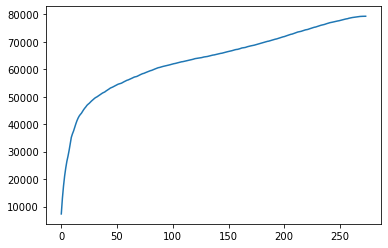

In [77]:
appear_date['cnt'].plot()

In [86]:
q = 0.9
np.quantile(appear_date['cnt'], q, axis = 0), data.client_pin.nunique() - np.quantile(appear_date['cnt'], q, axis = 0)

(77348.2, 1919.800000000003)